## Importing all modules we need 

In [273]:
import pandas as pd
import numpy as np
import os 
import glob

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Functions part 

In [85]:
def get_categorical_and_numerical_columns(df):
    """
    Identifies and returns lists of categorical and numerical columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        categorical_columns (list): List of categorical column names.
        numerical_columns (list): List of numerical column names.
    """
    # Identify categorical columns (object or category dtype)
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Identify numerical columns (int or float dtype)
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    return categorical_columns, numerical_columns

In [86]:
def nulls_df(df, column_type=None, percentage_threshold=0):
    """
    Computes the count and percentage of null values in a DataFrame using Dask for memory optimization.
    
    Args:
        df (dask.dataframe.DataFrame): The input Dask DataFrame.
        column_type (str, optional): The type of columns to filter ('Categorical' or 'Numerical').
        percentage_threshold (int, optional): The minimum percentage of null values to include.
        
    Returns:
        tuple: A tuple containing the filtered DataFrame and a list of column names.
    """
    
    # Compute null counts and percentages
    nulls_counts = df.isna().sum()
    nulls_percentages = (nulls_counts / df.shape[0]) * 100
    
    # Identify column types
    column_types = df.dtypes.apply(lambda x: 'Numerical' if x.kind in 'bifc' else 'Categorical')
    
    # Create a DataFrame for null information
    null_df = pd.DataFrame({
        'Column': nulls_counts.index,
        'Nulls_Count': nulls_counts,
        'Nulls_Percentage': nulls_percentages,
        'Type': column_types
    })
    
    # Filter based on column type if specified
    if column_type:
        null_df = null_df[null_df['Type'] == column_type]
    
    # Filter based on null percentage threshold
    null_df = null_df[null_df['Nulls_Percentage'] >= percentage_threshold]
    
    # Reset index to default numeric indices
    null_df = null_df.reset_index(drop=True)
    
    # Return the filtered DataFrame and a list of column names
    column_list = null_df['Column'].tolist()
    return null_df, column_list    

In [ ]:
def compare_models(X, y, cv=5):
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression":  LogisticRegression(),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
        "SVM": make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))
    }
    
    # Voting Classifier
    voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='soft')
    models["Voting Classifier"] = voting_clf
    
    results = {}
    
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        results[name] = scores.mean()
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results.items(), columns=["Model", "Accuracy"])
    results_df = results_df.sort_values(by="Accuracy", ascending=False)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.barh(results_df["Model"], results_df["Accuracy"], color='skyblue')
    plt.xlabel("Accuracy")
    plt.ylabel("Model")
    plt.title("Model Comparison - Cross Validation Accuracy")
    plt.xlim(0, 1)
    for index, value in enumerate(results_df["Accuracy"]):
        plt.text(value, index, f"{value:.3f}")
    plt.gca().invert_yaxis()
    plt.show()
    
    return results_df


In [ ]:
import pandas as pd
import numpy as np

def drop_low_importance_features(model, feature_names, threshold=0.009):
    importances = model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Filter features based on the threshold
    retained_features = feature_importance_df[feature_importance_df['importance'] >= threshold]['feature'].tolist()
    dropped_features = feature_importance_df[feature_importance_df['importance'] < threshold]['feature'].tolist()
    
    return retained_features, dropped_features


In [87]:
def get_categorical_and_numerical_columns(df):
    """
    Identifies and returns lists of categorical and numerical columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        categorical_columns (list): List of categorical column names.
        numerical_columns (list): List of numerical column names.
    """
    # Identify categorical columns (object or category dtype)
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Identify numerical columns (int or float dtype)
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    return categorical_columns, numerical_columns

In [88]:
import re
import html
import unicodedata
import string

# Define a list of stop words (you can expand this as needed)
STOP_WORDS = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
    "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
    "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that",
    "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had",
    "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as",
    "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through",
    "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",
    "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how",
    "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not",
    "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should",
    "now"
])

def normalize_text_series(text):
    # Step 1: Remove special characters and escape sequences
    re1 = re.compile(r'  +')
    text = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(text))
    
    # Step 2: Remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Step 3: Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    # Step 4: Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Step 5: Tokenize words (split into a list of words)
    words = text.split()
    
    # Step 6: Remove stopwords
    words = [word for word in words if word not in STOP_WORDS]
    
    # Step 7: Return the cleaned text as a single string
    return ' '.join(words)


In [89]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the input DataFrame by performing the following steps:
    1. Handle missing values based on specified rules
    Parameters:
    df (pd.DataFrame): Input DataFrame to be cleaned

    Returns:
    pd.DataFrame: Cleaned DataFrame
    """
    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().mean() * 100

    # Drop columns with more than 60% missing values
    cols_to_drop = missing_percentage[missing_percentage > 60].index
    df.drop(columns=cols_to_drop, inplace=True)

    # Fill missing values for columns with 5% to 60% missing values
    for col in missing_percentage[(missing_percentage >= 5) & (missing_percentage <= 60)].index:
        if df[col].dtype == 'object':
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
        elif pd.api.types.is_numeric_dtype(df[col]):
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col].fillna(method='ffill', inplace=True)
            df[col].fillna(method='bfill', inplace=True)

    # Drop rows with missing values in columns with less than 5% missing values
    df.dropna(axis=0, inplace=True)
    
    return df

## Preprocessing part 

In [90]:
# Getting the current directory and obtian all csv files 

current_directory = os.getcwd()# Getting the current directory 
csv_files = glob.glob(f"{current_directory}/*.csv")
csv_files


['d:\\Projects\\Ch1\\Youtube01-Psy.csv',
 'd:\\Projects\\Ch1\\Youtube02-KatyPerry.csv',
 'd:\\Projects\\Ch1\\Youtube03-LMFAO.csv',
 'd:\\Projects\\Ch1\\Youtube04-Eminem.csv',
 'd:\\Projects\\Ch1\\Youtube05-Shakira.csv']

In [91]:
# Check if all the files has the same attributes 
attributes = []

for file in csv_files:
    list_items = pd.read_csv(f"{file}").columns.tolist()
    if list_items not in attributes:
        attributes.append(list_items)

attributes

[['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS']]

* Now these files have the same attributes then we can 

In [92]:
# Concate all the files in one file 
dfs = [pd.read_csv(item) for item in csv_files ]
for index, item in enumerate(dfs):
    item['Vide0'] = index  
merged_df = pd.concat(dfs, ignore_index=True)

In [93]:
# Drop comment_id column 
merged_df = merged_df.drop('COMMENT_ID', axis=1)

In [94]:
# Rename fields 
df = merged_df.rename(columns={'CONTENT':'text', "CLASS":"label" })

In [95]:
# Lower all the items here 
for column in df:
    lower_column = column.lower()
    df = df.rename(columns={f"{column}":f"{lower_column}"})

In [96]:
df

,author,date,text,label,vide0
0,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,0
1,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,0
2,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,0
3,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,0
4,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,0
...,...,...,...,...,...
1951,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0,4
1952,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0,4
1953,jeffrey jules,2013-07-13T12:09:31.188000,wow,0,4
1954,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0,4


In [97]:
nulls_df(df)

(   Column  Nulls_Count  Nulls_Percentage         Type
 0  author            0          0.000000  Categorical
 1    date          245         12.525562  Categorical
 2    text            0          0.000000  Categorical
 3   label            0          0.000000    Numerical
 4   vide0            0          0.000000    Numerical,
 ['author', 'date', 'text', 'label', 'vide0'])

In [98]:
# First convert the date column to a time data column
df['date'] = pd.to_datetime(df['date'], format='ISO8601') 

In [99]:
# Extract separate columns 
df['date'] = df['date'].dt.date # Extract date 

In [100]:
df.head()

,author,date,text,label,vide0
0,Julius NM,2013-11-07,"Huh, anyway check out this you[tube] channel: ...",1,0
1,adam riyati,2013-11-07,Hey guys check out my new channel and our firs...,1,0
2,Evgeny Murashkin,2013-11-08,just for test I have to say murdev.com,1,0
3,ElNino Melendez,2013-11-09,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,0
4,GsMega,2013-11-10,watch?v=vtaRGgvGtWQ Check this out .﻿,1,0


In [101]:
new_df = clean_data(df)

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_7092\2381801109.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [102]:
new_df.info() # Now there is no null values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   author  1956 non-null   object
 1   date    1956 non-null   object
 2   text    1956 non-null   object
 3   label   1956 non-null   int64 
 4   vide0   1956 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 76.5+ KB


## visualization 

Text(0, 0.5, 'Count')

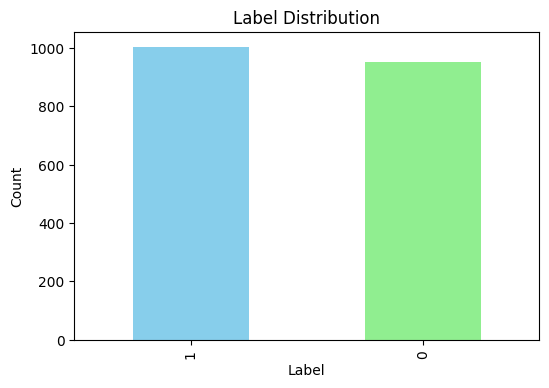

In [103]:
# Visualize label distribution to understand the balance of my data 

new_df['label'].value_counts().plot(kind='bar', figsize =(6,4), title="Label Distribution", color = ['skyblue', 'lightgreen'])
plt.xlabel("Label")
plt.ylabel("Count")




In [104]:
visualize = new_df.copy()

Text(0, 0.5, 'Number of Comments')

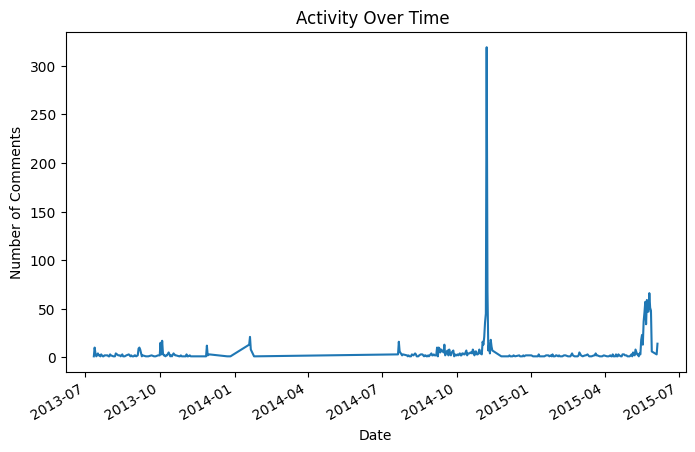

In [105]:
visualize['date'] = pd.to_datetime(visualize['date'])
activity_over_time = visualize.groupby('date')['date'].count()
activity_over_time.plot(kind='line', figsize=(8, 5), title = "Activity Over Time ")
plt.xlabel('Date')
plt.ylabel('Number of Comments')

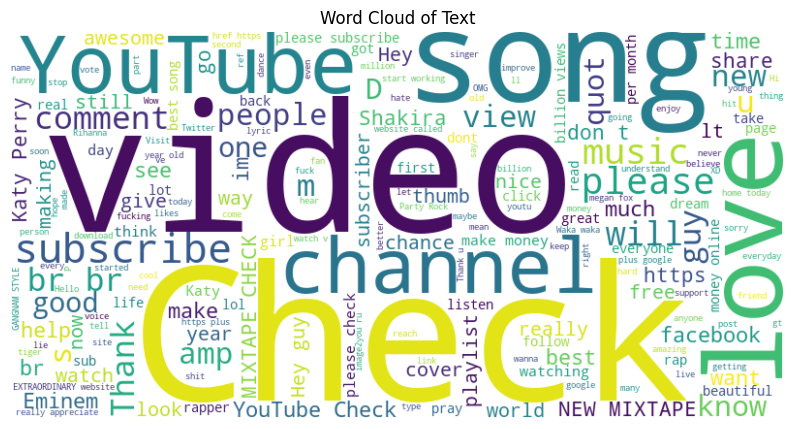

In [106]:
from wordcloud import WordCloud

# Generate a word cloud
text_data = ' '.join(new_df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text')
plt.show()


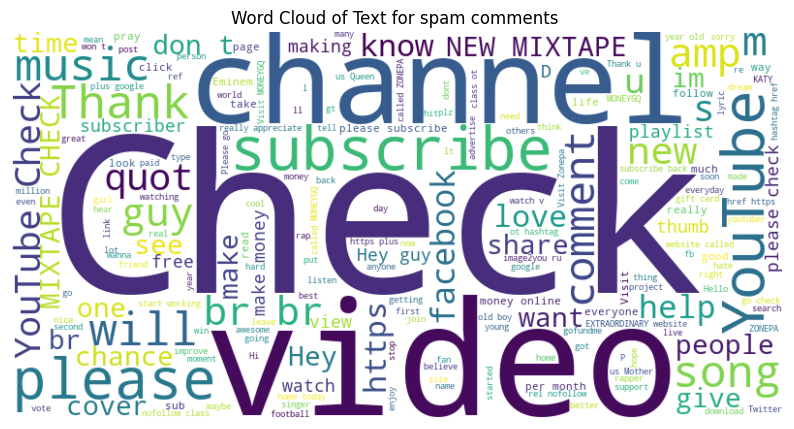

In [107]:
from wordcloud import WordCloud

# the most frequent words in spam comments 

spam_comments = new_df[new_df['label'] == 1] 

text_data = ' '.join(spam_comments['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text for spam comments ')
plt.show()


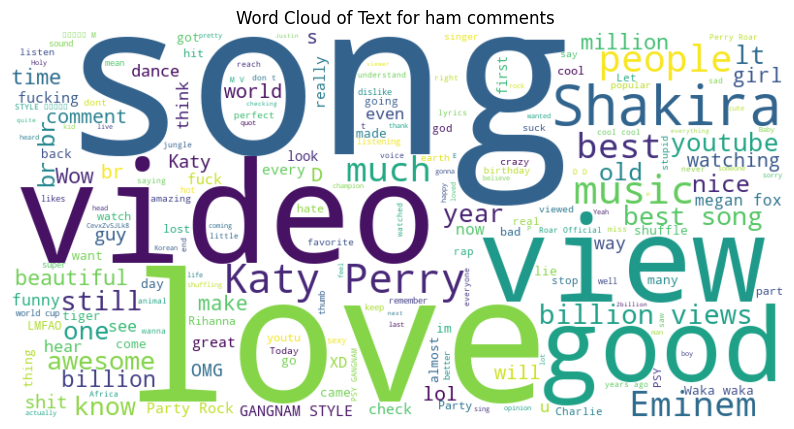

In [108]:
from wordcloud import WordCloud

# the most frequent words in ham comments 

spam_comments = new_df[new_df['label'] == 0] 

text_data = ' '.join(spam_comments['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text for ham comments ')
plt.show()

In [109]:
copied_df = new_df.copy()

## Feature Engineering 

In [110]:
spam_keywords = ["channel", "subscribe", "check", "please", "link"]
ham_keywords = ["song", "love", "video", "good"]
for keyword in spam_keywords:
    copied_df[f"contains_{keyword}"] = copied_df['text'].str.contains(keyword, case=False, na=False).astype(int)
for keyword in ham_keywords:
    copied_df[f"contains_{keyword}"] = copied_df['text'].str.contains(keyword, case=False, na=False).astype(int)

In [111]:
copied_df

,author,date,text,label,vide0,contains_channel,contains_subscribe,contains_check,contains_please,contains_link,contains_song,contains_love,contains_video,contains_good
0,Julius NM,2013-11-07,"Huh, anyway check out this you[tube] channel: ...",1,0,1,0,1,0,0,0,0,0,0
1,adam riyati,2013-11-07,Hey guys check out my new channel and our firs...,1,0,1,1,1,1,0,0,0,0,0
2,Evgeny Murashkin,2013-11-08,just for test I have to say murdev.com,1,0,0,0,0,0,0,0,0,0,0
3,ElNino Melendez,2013-11-09,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,0,1,0,0,0,0,0,0,0,0
4,GsMega,2013-11-10,watch?v=vtaRGgvGtWQ Check this out .﻿,1,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,Katie Mettam,2013-07-13,I love this song because we sing it at Camp al...,0,4,0,0,0,0,0,1,1,0,0
1952,Sabina Pearson-Smith,2013-07-13,I love this song for two reasons: 1.it is abou...,0,4,0,0,0,0,0,1,1,0,0
1953,jeffrey jules,2013-07-13,wow,0,4,0,0,0,0,0,0,0,0,0
1954,Aishlin Maciel,2013-07-13,Shakira u are so wiredo,0,4,0,0,0,0,0,0,0,0,0


In [112]:
# Now the time to train the model 

copied_df['normalized_text'] = copied_df['text'].apply(normalize_text_series)


In [113]:
copied_df.drop(['text'],axis=1, inplace=True)

In [114]:
copied_df.drop(['author'],axis=1, inplace=True)

In [115]:
# Convert date to datetime and extract features
copied_df['date'] = pd.to_datetime(copied_df['date'])
copied_df['Year'] = copied_df['date'].dt.year
copied_df['Month'] = copied_df['date'].dt.month
copied_df['Day'] = copied_df['date'].dt.day

# Convert time to numerical features
# copied_df['time_contains_channel'] = pd.to_timedelta(copied_df['time_contains_channel']).dt.total_seconds()

In [116]:
copied_df.drop(columns=['date'],axis=1, inplace=True)
copied_df

,label,vide0,contains_channel,contains_subscribe,contains_check,contains_please,contains_link,contains_song,contains_love,contains_video,contains_good,normalized_text,Year,Month,Day
0,1,0,1,0,1,0,0,0,0,0,0,huh anyway check youtube channel kobyoshi,2013,11,7
1,1,0,1,1,1,1,0,0,0,0,0,hey guys check new channel first vid us monkey...,2013,11,7
2,1,0,0,0,0,0,0,0,0,0,0,test say murdevcom,2013,11,8
3,1,0,1,0,0,0,0,0,0,0,0,shaking sexy ass channel enjoy,2013,11,9
4,1,0,0,0,1,0,0,0,0,0,0,watchvvtarggvgtwq check,2013,11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,0,4,0,0,0,0,0,1,1,0,0,love song sing camp time,2013,7,13
1952,0,4,0,0,0,0,0,1,1,0,0,love song two reasons africa born beautiful so...,2013,7,13
1953,0,4,0,0,0,0,0,0,0,0,0,wow,2013,7,13
1954,0,4,0,0,0,0,0,0,0,0,0,shakira u wiredo,2013,7,13


In [117]:
copied_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   label               1956 non-null   int64 
 1   vide0               1956 non-null   int64 
 2   contains_channel    1956 non-null   int64 
 3   contains_subscribe  1956 non-null   int64 
 4   contains_check      1956 non-null   int64 
 5   contains_please     1956 non-null   int64 
 6   contains_link       1956 non-null   int64 
 7   contains_song       1956 non-null   int64 
 8   contains_love       1956 non-null   int64 
 9   contains_video      1956 non-null   int64 
 10  contains_good       1956 non-null   int64 
 11  normalized_text     1956 non-null   object
 12  Year                1956 non-null   int32 
 13  Month               1956 non-null   int32 
 14  Day                 1956 non-null   int32 
dtypes: int32(3), int64(11), object(1)
memory usage: 206.4+ KB


## Training model 

In [118]:
# Creating a pipleline for numerica features or categorical features
numerical_transformer  = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("StandardScaler", StandardScaler())
])
categorical_transformer  = Pipeline([
    ('oneHot', OneHotEncoder())
])

In [119]:
vectorize = CountVectorizer()
bow_matrix = vectorize.fit_transform(copied_df['normalized_text'])
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorize.get_feature_names_out())

In [120]:
final_df = pd.concat([copied_df.drop(columns=['normalized_text']), bow_df], axis=1)

In [121]:
# Splitting the data into x_data and y_data 
X = final_df.drop(['label'], axis=1)
Y = final_df['label']

In [122]:
numerical_features = X.select_dtypes(include=['number']).columns.to_list()
categorical_features= X.select_dtypes(include=['object']).columns.to_list()

In [123]:
preprocessor = ColumnTransformer(
    [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [124]:
# Split the data into train data and val, test data 
X_train, X_val, Y_trian, Y_val = train_test_split(X, Y, test_size=.4, random_state=42, stratify=Y)

In [125]:
# Split the data into val and test 

X_valid, X_test, Y_valid, Y_test = train_test_split(X_val, Y_val, test_size=.4, random_state=42, stratify=Y_val)

In [126]:
x_train = preprocessor.fit_transform(X_train)
# x_valid = preprocessor.transform(X_valid)
# x_test = preprocessor.transform(X_test)

In [127]:
# Transform the validation/test data using the same preprocessor
x_valid = preprocessor.transform(X_valid)
x_test = preprocessor.transform(X_test)

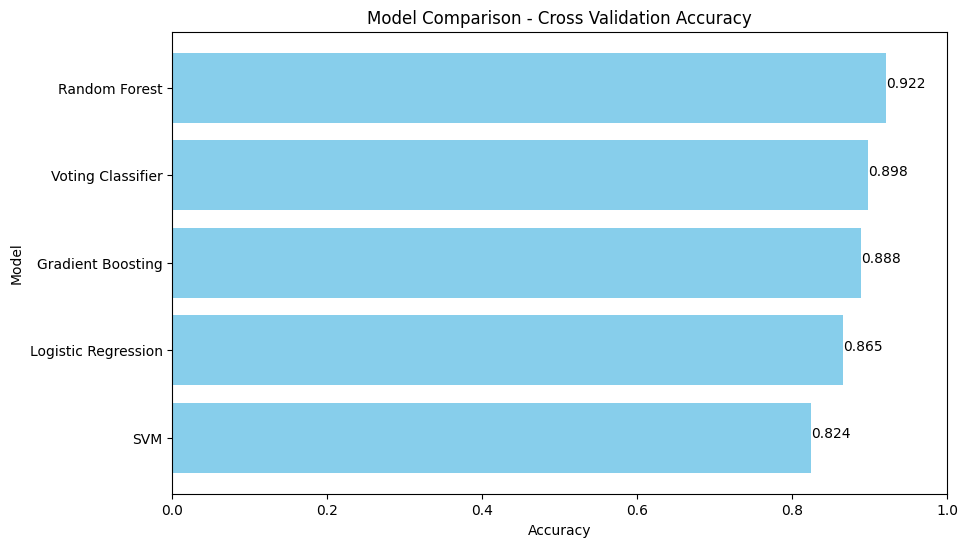

In [129]:
result_df = compare_models(x_train, Y_trian)

In [130]:
# Now we will work on the random forest classifier to tune the hyperprams 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize the classifier
rf = RandomForestClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, Y_trian)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [158]:
best_params = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 300
}
best_model_2 = RandomForestClassifier(**best_params, random_state=42)

In [134]:
from sklearn.metrics import accuracy_score, classification_report

# Use the best parameters
best_model = grid_search.best_estimator_ 

# Predict on the test set
y_pred = best_model.predict(x_valid)

# Evaluate
print("Accuracy:", accuracy_score(Y_valid, y_pred))
print("Classification Report:\n", classification_report(Y_valid, y_pred))

Accuracy: 0.9189765458422174
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       228
           1       0.97      0.87      0.92       241

    accuracy                           0.92       469
   macro avg       0.92      0.92      0.92       469
weighted avg       0.92      0.92      0.92       469



In [135]:
Y_PRE = best_model.predict(x_train)

# Evaluate
print("Accuracy:", accuracy_score(Y_trian, Y_PRE))
print("Classification Report:\n", classification_report(Y_trian, Y_PRE))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       570
           1       1.00      1.00      1.00       603

    accuracy                           1.00      1173
   macro avg       1.00      1.00      1.00      1173
weighted avg       1.00      1.00      1.00      1173



* the model is over fitting so we need to reduce dimentions 

In [211]:
best_model.feature_importances_

array([2.56053397e-02, 2.07811239e-02, 3.64953377e-02, ...,
       0.00000000e+00, 9.26413486e-05, 1.68236784e-04], shape=(3804,))

In [263]:
feature_names = X_train.columns.to_list()
retained_features, droped_features  = drop_low_importance_features(best_model, feature_names)

In [264]:
# Split the data into train data and val, test data 
final_X_train, final_X_val, final_Y_trian, final_Y_val = train_test_split(X[retained_features], Y, test_size=.4, random_state=42, stratify=Y)
final_X_valid, final_X_test, final_Y_valid, final_Y_test = train_test_split(final_X_val, final_Y_val, test_size=.4, random_state=42, stratify=Y_val)

In [265]:
numerical_features = final_X_train.select_dtypes(include=['number']).columns.to_list()
categorical_features= final_X_train.select_dtypes(include=['object']).columns.to_list()

In [266]:
preprocessor = ColumnTransformer(
    [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [267]:
f_x_train = preprocessor.fit_transform(final_X_train)
f_x_valid = preprocessor.transform(final_X_valid)
f_x_test = preprocessor.transform(final_X_test)

In [268]:
best_model_2.fit(final_X_train, final_Y_trian)

# Predict on the test set
final_y_pred = best_model_2.predict(final_X_valid)

# Evaluate
print("Accuracy:", accuracy_score(final_Y_valid, final_y_pred))
print("Classification Report:\n", classification_report(final_Y_valid, final_y_pred))

Accuracy: 0.8933901918976546
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.90       228
           1       0.94      0.85      0.89       241

    accuracy                           0.89       469
   macro avg       0.90      0.89      0.89       469
weighted avg       0.90      0.89      0.89       469



In [269]:
final_Y_PRE = best_model_2.predict(final_X_train)

# Evaluate
print("Accuracy:", accuracy_score(final_Y_trian, final_Y_PRE))
print("Classification Report:\n", classification_report(final_Y_trian, final_Y_PRE))

Accuracy: 0.9599317988064792
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       570
           1       0.98      0.94      0.96       603

    accuracy                           0.96      1173
   macro avg       0.96      0.96      0.96      1173
weighted avg       0.96      0.96      0.96      1173



In [270]:
from xgboost import XGBClassifier

# Use early stopping
model = XGBClassifier()
model.fit(final_X_train, final_Y_trian)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [271]:
# Predict on the test set
final_y_pred = model.predict(final_X_valid)

# Evaluate
print("Accuracy:", accuracy_score(final_Y_valid, final_y_pred))
print("Classification Report:\n", classification_report(final_Y_valid, final_y_pred))

Accuracy: 0.8912579957356077
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       228
           1       0.94      0.85      0.89       241

    accuracy                           0.89       469
   macro avg       0.89      0.89      0.89       469
weighted avg       0.90      0.89      0.89       469



In [272]:
final_Y_PRE = model.predict(final_X_train)

# Evaluate
print("Accuracy:", accuracy_score(final_Y_trian, final_Y_PRE))
print("Classification Report:\n", classification_report(final_Y_trian, final_Y_PRE))

Accuracy: 0.9497016197783461
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       570
           1       0.98      0.93      0.95       603

    accuracy                           0.95      1173
   macro avg       0.95      0.95      0.95      1173
weighted avg       0.95      0.95      0.95      1173



## Tunning the best prams for xgboost 

In [275]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 10),
    'reg_lambda': uniform(0, 10)
}

# Initialize the classifier
model = XGBClassifier(random_state=42)

# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(final_X_train, final_Y_trian)

# Best parameters
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'colsample_bytree': np.float64(0.6605368512187832), 'gamma': np.float64(0.6840118557792579), 'learning_rate': np.float64(0.24788759619637277), 'max_depth': 9, 'n_estimators': 469, 'reg_alpha': np.float64(1.9074715630343453), 'reg_lambda': np.float64(2.76619033284617), 'subsample': np.float64(0.7364590503405393)}


In [276]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Best parameters found
best_params = {
    'colsample_bytree': 0.6605368512187832,
    'gamma': 0.6840118557792579,
    'learning_rate': 0.24788759619637277,
    'max_depth': 9,
    'n_estimators': 469,
    'reg_alpha': 1.9074715630343453,
    'reg_lambda': 2.76619033284617,
    'subsample': 0.7364590503405393
}

# Define a smaller grid around the best parameters
param_grid = {
    'colsample_bytree': [best_params['colsample_bytree'] - 0.05, best_params['colsample_bytree'], best_params['colsample_bytree'] + 0.05],
    'gamma': [best_params['gamma'] - 0.1, best_params['gamma'], best_params['gamma'] + 0.1],
    'learning_rate': [best_params['learning_rate'] - 0.02, best_params['learning_rate'], best_params['learning_rate'] + 0.02],
    'max_depth': [best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1],
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'reg_alpha': [best_params['reg_alpha'] - 0.5, best_params['reg_alpha'], best_params['reg_alpha'] + 0.5],
    'reg_lambda': [best_params['reg_lambda'] - 0.5, best_params['reg_lambda'], best_params['reg_lambda'] + 0.5],
    'subsample': [best_params['subsample'] - 0.05, best_params['subsample'], best_params['subsample'] + 0.05]
}

# Initialize the classifier
model = XGBClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(final_X_train, final_Y_trian)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.7105368512187833, 'gamma': 0.584011855779258, 'learning_rate': 0.26788759619637276, 'max_depth': 10, 'n_estimators': 519, 'reg_alpha': 1.4074715630343453, 'reg_lambda': 3.26619033284617, 'subsample': 0.7364590503405393}
Best Score: 0.9002691398436079


In [279]:
final_Y_PRE = grid_search.best_estimator_.predict(final_X_train)

# Evaluate
print("Accuracy:", accuracy_score(final_Y_trian, final_Y_PRE))
print("Classification Report:\n", classification_report(final_Y_trian, final_Y_PRE))

Accuracy: 0.9181585677749361
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       570
           1       0.96      0.88      0.92       603

    accuracy                           0.92      1173
   macro avg       0.92      0.92      0.92      1173
weighted avg       0.92      0.92      0.92      1173



In [280]:
# Predict on the test set
final_y_pred = grid_search.best_estimator_.predict(final_X_valid)

# Evaluate
print("Accuracy:", accuracy_score(final_Y_valid, final_y_pred))
print("Classification Report:\n", classification_report(final_Y_valid, final_y_pred))

Accuracy: 0.8891257995735607
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       228
           1       0.95      0.83      0.88       241

    accuracy                           0.89       469
   macro avg       0.89      0.89      0.89       469
weighted avg       0.90      0.89      0.89       469





### **Lessons Learned and Challenges Encountered**

In this project, we encountered several challenges while building a YouTube comment spam/ham classification model using a balanced dataset and XGBoost. Below, we outline these challenges and the solutions we implemented to address them.

---

#### **1. Data Quality Issues**
**Challenges**:
- Inconsistent date formats in the `date` column.
- Noisy text data, including URLs, special characters, and incomplete sentences.
- Potential missing values in key columns like `text`, `label`, or `video`.

**Solutions**:
- Standardized date formats using `pandas.to_datetime()`.
- Cleaned text data by removing URLs, special characters, and stopwords using regex and `nltk`.
- Handled missing values by dropping rows with missing `text` or imputing them based on context.

---

#### **2. Text Preprocessing**
**Challenges**:
- Text data is unstructured and requires extensive preprocessing to make it suitable for modeling.
- The presence of irrelevant words and variations in word forms (e.g., "run" vs. "running").

**Solutions**:
- Tokenized text into individual words using `nltk.word_tokenize()`.
- Removed stopwords using `nltk.corpus.stopwords`.
- Applied stemming or lemmatization to reduce words to their base forms using `nltk.PorterStemmer` or `nltk.WordNetLemmatizer`.

---

#### **3. Feature Engineering**
**Challenges**:
- Converting raw text data into numerical features that can be used by machine learning models.

**Solutions**:
- Used **Bag of Words (BoW)** to convert text into a matrix of word counts.

---

#### **4. Model Selection and Tuning**
**Challenges**:
- Choosing the right model and tuning its hyperparameters for optimal performance.
- Ensuring the model generalizes well to unseen data without overfitting.

**Solutions**:
- Started with **XGBoost** as the primary model due to its robustness and ability to handle structured data.
- Performed **hyperparameter tuning** using `GridSearchCV` and `RandomizedSearchCV` to find the best combination of parameters.
- Used **early stopping** to prevent overfitting and reduce training time.

---

#### **5. Evaluation and Interpretation**
**Challenges**:
- Evaluating model performance on imbalanced data (even though the dataset was balanced, ensuring robustness for future imbalances).
- Interpreting the model's predictions to understand why certain comments were classified as spam or ham.

**Solutions**:
- Used evaluation metrics like **precision, recall, F1-score** to assess model performance.